# DTMC/CTMC consistency

Using the 11-state Weiss chain, we (1) converted a CTMC to a DTMC via matrix exponential and confirmed that the inter-microstate MFPTs are identical in both cases, and (2) converted a DTMC to a CTMC via Eq. 11 of JCP-KSSW-2020 and computed the MFPTs on the resulting CTMC and found that it matches the MFPTs from the original CTMC.

In [2]:
import PyGT

import numpy as np
from numpy.linalg import inv
import scipy 
import scipy.linalg as spla 
from scipy.sparse.linalg import eigs
from scipy.sparse import csr_matrix
from scipy.linalg import eig
from scipy.linalg import expm
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
from scipy.interpolate import CubicSpline
import seaborn as sns
sns.set()

# Weiss chain calculations

In [3]:
#Weiss chain
path = Path('KTN_data/chain')
mindata = np.loadtxt(path/'min.data')
tsdata = np.loadtxt(path/'ts.data')

nmin = mindata.shape[0]
emin = mindata[:,0]
fvibmin = mindata[:, 1]
hordermin = mindata[:, 2]

ets = np.zeros((nmin, nmin))
fvibts = np.zeros((nmin, nmin))
horderts = np.ones((nmin, nmin))
exist = np.zeros((nmin, nmin))

for i in range(tsdata.shape[0]):
    j1 = int(tsdata[i, 3]) - 1
    j2 = int(tsdata[i, 4]) - 1
    exist[j1, j2] = 1
    exist[j2, j1] = 1
    ets[j1, j2] = tsdata[i, 0]
    ets[j2, j1] = tsdata[i, 0]
    fvibts[j1, j2] = tsdata[i, 1]
    fvibts[j2, j1] = tsdata[i, 1]
    horderts[j1, j2] = tsdata[i, 2]
    horderts[j2, j1] = tsdata[i, 2]

def Kmat(temp):
    """Return a rate matrix, nmin x nmin for specified temperature."""
    K = np.zeros((nmin, nmin), dtype=np.longdouble)
    for j in range(nmin):
        vib = np.exp((fvibmin - fvibts[:,j])/2).astype(np.longdouble)
        order = hordermin/(2*np.pi*horderts[:,j])
        nrg = np.exp(-(ets[:,j] - emin)/temp).astype(np.longdouble)
        K[:, j] = exist[:, j]*vib*order*nrg

    K = K.T
    for i in range(nmin):
        K[i, i] = -np.sum(K[:,i])
    #return transpose since ts.data assumes i->j and we want i<-j
    return K

def peq(temp):
    """Return equilibrium probabilities for specified temperature."""
    zvec = np.exp(-fvibmin/2)*np.exp(-emin/temp)/hordermin
    zvec = zvec.astype(np.longdouble)
    return zvec/np.sum(zvec)

def weiss(temp):
    """Return the matrix of mean first passage times using the recursive
    formulae in Weiss (1967) Adv. Chem. Phys. 13, 1-18."""
    K = Kmat(temp)
    def eta(j):
        if j == 0:
            return 0
        else:
            return (K[j, j-1]*eta(j-1) + 1)/K[j-1, j]

    def theta(j):
        if j==0:
            return 1
        else:
            return theta(j-1)*K[j, j-1]/K[j-1, j]

    etavec = [eta(j) for j in range(0, nmin-1)]
    thetavec = [theta(j) for j in range(0, nmin-1)]
    tmean_oneton = lambda n: (eta(n)/theta(n))*np.sum(thetavec[0:n]) - np.sum(etavec[0:n]) 

    def xeta(j):
        if j == nmin-1:
            return 0
        else:
            return (K[j, j+1]*xeta(j+1) + 1)/K[j+1, j]

    def xtheta(j):
        if j == nmin-1:
            return 1
        else:
            return xtheta(j+1)*K[j, j+1]/K[j+1, j]

    xetavec = [xeta(j) for j in range(1, nmin)]
    xthetavec = [xtheta(j) for j in range(1, nmin)]
    tmean_nmintoone = lambda n: (xeta(n)/xtheta(n))*np.sum(xthetavec[n:nmin-1]) - np.sum(xetavec[n:nmin-1]) 
    mfpt = np.zeros((nmin, nmin), dtype=np.longdouble)
    for i in range(0, nmin):
        for j in range(0, i):
            mfpt[i][j] = tmean_oneton(i) - tmean_oneton(j)
        for j in range(i+1, nmin):
            mfpt[i][j] = tmean_nmintoone(i) - tmean_nmintoone(j)
    return mfpt

## Convert a CTMC to a DTMC via matrix exponeniation

In [6]:
beta = 5 #T=0.20
#B is branching probability matrix, wait_CT is vector of waiting times
B, Knodiag, wait_CT, N, u, s, Emin, retained = PyGT.io.load_ktn('KTN_data/chain', beta=beta)
K = Kmat(1/beta) #CTMC
pi = peq(1/beta) #stationary probabilities
tau = 0.001 #lag time
T = expm(K*tau) #DTMC
wait_DT = np.tile(tau, 11) #vector of lag times
print(T.sum(axis=0))
print(K.sum(axis=0))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 9.92616735e-23 0.00000000e+00 0.00000000e+00 9.92616735e-23 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]


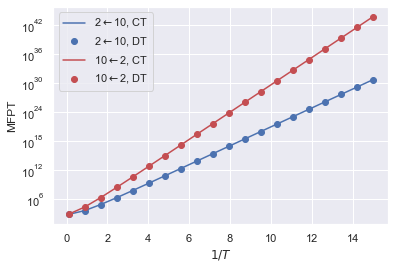

In [13]:
#compare 2<->10 inter-microstate MFPTs produced from CTMC to those produced from ``equivalent" DTMC
betas = np.linspace(0.1, 15, 20)
mfpt2_10_CT = np.zeros((len(betas), 2))
mfpt2_10_DT = np.zeros((len(betas), 2))
for i,beta in enumerate(betas):
    B, Knodiag, wait_CT, N, u, s, Emin, retained = PyGT.io.load_ktn('KTN_data/chain', beta=beta)
    K = Kmat(1/beta)
    T = expm(K*tau)
    #continuous time computation
    mfpt2_10_CT[i,0], mfpt2_10_CT[i,1] = PyGT.mfpt.compute_MFPT(1,9,B,wait_CT)
    #discrete time
    mfpt2_10_DT[i,0], mfpt2_10_DT[i,1] = PyGT.mfpt.compute_MFPT(1,9,T,wait_DT)

fig, ax = plt.subplots()
ax.plot(betas, mfpt2_10_CT[:,0], 'b-', label='2$\leftarrow$10, CT')
ax.plot(betas, mfpt2_10_DT[:,0], 'bo', label='2$\leftarrow$10, DT')
ax.plot(betas, mfpt2_10_CT[:,1], 'r-', label='10$\leftarrow$2, CT')
ax.plot(betas, mfpt2_10_DT[:,1], 'ro', label='10$\leftarrow$2, DT')
plt.yscale('log')
plt.xlabel(r'$1/T$')
plt.ylabel('MFPT')
plt.legend()

## Convert DTMC back to CTMC via inversion of MFPT matrix

In [28]:
betas = np.linspace(0.1, 5, 20)
mfpt2_10_CT2 = np.zeros((len(betas), 2))
mfpt2_10_DT2 = np.zeros((len(betas), 2))
for i,beta in enumerate(betas):
    B, Knodiag, wait_CT, N, u, s, Emin, retained = PyGT.io.load_ktn('KTN_data/chain', beta=beta)
    K = Kmat(1/beta)
    T = expm(K*tau)
    pi = peq(1/beta)
    #get back CTMC from inversion of MFPT matrix
    mfptCT = PyGT.mfpt.full_MFPT_matrix(B, wait_CT)
    KfromMFPT_CT = spla.inv(mfptCT)@(-np.ones((11,11)) + spla.inv(np.diag(pi)))
    #compute 2<->10 MFPTs from the resultant CTMC
    waitCTfromMFPT = -1/np.diag(KfromMFPT_CT)
    Knodiag = KfromMFPT_CT - np.diag(np.diag(KfromMFPT_CT))
    D = -1*np.diag(np.diag(KfromMFPT_CT))
    BfromMFPT_CT = Knodiag@spla.inv(D)
    mfpt2_10_CT2[i,0], mfpt2_10_CT2[i,1] = PyGT.mfpt.compute_MFPT(1,9,BfromMFPT_CT,waitCTfromMFPT)
    #discrete time to CTMC via inversion of MFPT matrix
    mfptDT = PyGT.mfpt.full_MFPT_matrix(T, wait_DT)
    KfromMFPT_DT = spla.inv(mfptDT)@(-np.ones((11,11)) + spla.inv(np.diag(pi)))
    #compute 2<->10 MFPTs from the resultant CTMC
    waitDTfromMFPT = -1/np.diag(KfromMFPT_DT)
    Knodiag = KfromMFPT_DT - np.diag(np.diag(KfromMFPT_DT))
    D = -1*np.diag(np.diag(KfromMFPT_DT))
    BfromMFPT_DT = Knodiag@spla.inv(D)
    mfpt2_10_DT2[i,0], mfpt2_10_DT2[i,1] = PyGT.mfpt.compute_MFPT(1,9,BfromMFPT_DT,waitDTfromMFPT)


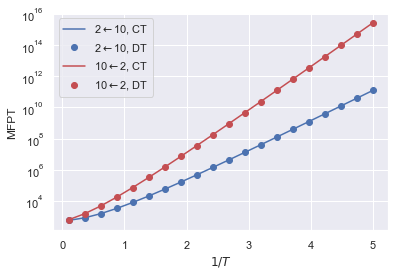

In [29]:
fig, ax = plt.subplots()
ax.plot(betas, mfpt2_10_CT2[:,0], 'b-', label='2$\leftarrow$10, CT')
ax.plot(betas, mfpt2_10_DT2[:,0], 'bo', label='2$\leftarrow$10, DT')
ax.plot(betas, mfpt2_10_CT2[:,1], 'r-', label='10$\leftarrow$2, CT')
ax.plot(betas, mfpt2_10_DT2[:,1], 'ro', label='10$\leftarrow$2, DT')
plt.yscale('log')
plt.xlabel(r'$1/T$')
plt.ylabel('MFPT')
plt.legend()

## Kemeny constants of DTMC and CTMC

In [95]:
beta = 0.1
B, Knodiag, wait_CT, N, u, s, Emin, retained = PyGT.io.load_ktn('KTN_data/chain', beta=beta)
K = Kmat(1./beta)
pi = peq(1./beta)
V = 11
pioneV = pi.reshape((V,1))@np.ones((1,11))
Z = spla.inv(pioneV + K) - pioneV
mfpt_fundCT = np.zeros((V,V))
mfptGTCT = PyGT.mfpt.full_MFPT_matrix(B, wait_CT)
for i in range(V):
    for j in range(V):
        mfpt_fundCT[i,j] = (Z[i,j] - Z[i,i])/pi[i]
kemeny = -1*np.trace(Z)
print(f'Trace of fundamental matrix: {kemeny}')
print(f'pi@mfpt from fundamental matrix: {(pi@mfpt_fundCT)[0]}')
print(f'pi@mfpt from PyGT: {(pi@mfptGTCT)[0]}')

Trace of fundamental matrix: 267.56807878611727
pi@mfpt from fundamental matrix: 267.56807878611727
pi@mfpt from PyGT: 267.56807878611716


In [97]:
#DTMC
tau = 0.000001
waitDT = np.tile(tau, V)
T = expm(K*tau)
Zdt = spla.inv(pioneV + np.eye(V,V) - T)
kemenyDT = np.trace(Zdt)
print(f'Trace of Kemeny and Snell fundamental matrix: {kemenyDT*tau}')

Trace of Kemeny and Snell fundamental matrix: 267.5680852100097


In [98]:
#group inverse
Ahash = Zdt - pioneV
print(f'Trace of Meyer group inverse: {tau*(np.trace(Ahash) + 1)}')

Trace of Meyer group inverse: 267.5680852100097


In [107]:
#Kemeny constant from MFPT matrix. 
#NOTE: if diagonals are set to zero, then the Kemeny constant is off by one
mfpt_fundDT = np.zeros((V,V))
for i in range(V):
    for j in range(V):
        if i==j:
            mfpt_fundDT[i,j] = 1/pi[i]
        else:
            mfpt_fundDT[i,j] = (Zdt[i,i] - Zdt[i,j])/pi[i]
print(f'Kemeny from fund mfpt matrix: {tau*(pi@mfpt_fundDT)[0]}')
mfptGTDT = PyGT.mfpt.full_MFPT_matrix(T, waitDT)
print(f'Kemeny from GT mfpt matrix: {(pi@mfptGTDT)[0]}')

Kemeny from fund mfpt matrix: 267.5680852100097
Kemeny from GT mfpt matrix: 267.56808378611726


In [108]:
#Eq (71) of Kells at al JCP (2020)
Dn = np.diag(pi)
Q = spla.inv(np.eye(V,V) - Dn@mfpt_fundDT)@(pioneV - Dn@mfpt_fundDT)
print(Q.sum(axis=0))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [109]:
#compute Kemeny constant of the new DTMC that you get from Eq 71
Zdt2 = spla.inv(pioneV + np.eye(V,V) - Q)
kemenyDT2 = np.trace(Zdt2)
print(tau*kemenyDT2)
mfpt_fundDT2 = np.zeros((V,V))
for i in range(V):
    for j in range(V):
        if i==j:
            mfpt_fundDT2[i,j] = 1/pi[i]
        else:
            mfpt_fundDT2[i,j] = (Zdt2[i,i] - Zdt2[i,j])/pi[i]
            
print(tau*(pi@mfpt_fundDT2)[0])

267.5682085900958
267.56820859009474328


In [110]:
#MFPTs from original DTMC match those of new DTMC via Eq. 71
print(mfpt_fundDT/mfpt_fundDT2)

[[1.         0.99999987 0.99999975 0.99999968 0.99999961 0.99999954 0.99999949 0.99999945 0.99999943 0.99999941 0.9999994 ]
 [1.00000101 1.         0.99999971 0.99999964 0.99999958 0.99999951 0.99999946 0.99999943 0.99999941 0.99999939 0.99999938]
 [1.00000083 1.00000082 1.         0.99999961 0.99999954 0.99999948 0.99999943 0.9999994  0.99999938 0.99999937 0.99999936]
 [1.00000054 1.00000053 1.00000052 1.         0.99999964 0.9999996  0.99999957 0.99999955 0.99999953 0.99999952 0.99999951]
 [1.00000031 1.00000031 1.0000003  1.0000003  1.         0.99999972 0.99999969 0.99999967 0.99999966 0.99999965 0.99999964]
 [0.99999996 0.99999996 0.99999997 0.99999997 0.99999998 1.         1.00000001 1.         1.         0.99999999 0.99999999]
 [0.99999967 0.99999967 0.99999969 0.9999997  0.99999972 0.99999975 1.         1.00000036 1.00000036 1.00000036 1.00000036]
 [0.99999945 0.99999946 0.99999948 0.9999995  0.99999953 0.99999957 0.99999962 1.         1.00000073 1.00000074 1.00000077]
 [0.9999

In [111]:
#MFPTs in DT match those in CT
print(mfptGTDT/mfptGTCT)

[[       nan 1.00000008 1.00000003 1.00000002 1.00000001 1.00000001 1.00000001 1.00000001 1.00000001 1.00000001 1.00000001]
 [1.00000063        nan 1.00000003 1.00000002 1.00000001 1.00000001 1.00000001 1.00000001 1.00000001 1.00000001 1.00000001]
 [1.0000001  1.00000012        nan 1.00000006 1.00000003 1.00000002 1.00000001 1.00000001 1.00000001 1.00000001 1.00000001]
 [1.00000007 1.00000007 1.00000014        nan 1.00000007 1.00000004 1.00000002 1.00000002 1.00000002 1.00000002 1.00000002]
 [1.00000004 1.00000005 1.00000006 1.00000011        nan 1.00000008 1.00000004 1.00000003 1.00000003 1.00000002 1.00000002]
 [1.00000003 1.00000003 1.00000004 1.00000005 1.00000009        nan 1.00000011 1.00000006 1.00000005 1.00000004 1.00000004]
 [1.00000002 1.00000002 1.00000002 1.00000003 1.00000004 1.00000007        nan 1.00000013 1.00000008 1.00000006 1.00000006]
 [1.00000001 1.00000002 1.00000002 1.00000002 1.00000002 1.00000003 1.00000006        nan 1.00000017 1.0000001  1.00000009]
 [1.0000

/Users/deepti/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [113]:
#mfpts from GT are just off by a factor of the lag time
print(mfptGTDT/mfpt_fundDT)

[[0.00000000e+00 9.99999998e-07 9.99999995e-07 9.99999995e-07 9.99999995e-07 9.99999996e-07 9.99999996e-07 9.99999996e-07 9.99999996e-07 9.99999996e-07
  9.99999996e-07]
 [1.00000001e-06 0.00000000e+00 9.99999994e-07 9.99999995e-07 9.99999995e-07 9.99999996e-07 9.99999996e-07 9.99999996e-07 9.99999996e-07 9.99999996e-07
  9.99999996e-07]
 [1.00000001e-06 1.00000001e-06 0.00000000e+00 1.00000000e-06 9.99999999e-07 9.99999999e-07 1.00000000e-06 1.00000000e-06 1.00000000e-06 9.99999999e-07
  9.99999999e-07]
 [1.00000000e-06 1.00000000e-06 9.99999999e-07 0.00000000e+00 9.99999998e-07 9.99999999e-07 1.00000000e-06 1.00000000e-06 1.00000000e-06 1.00000000e-06
  1.00000000e-06]
 [1.00000000e-06 1.00000000e-06 1.00000000e-06 1.00000000e-06 0.00000000e+00 1.00000000e-06 1.00000000e-06 1.00000000e-06 1.00000000e-06 1.00000000e-06
  1.00000000e-06]
 [9.99999998e-07 9.99999998e-07 9.99999999e-07 9.99999999e-07 9.99999999e-07 0.00000000e+00 1.00000000e-06 1.00000000e-06 1.00000000e-06 1.00000000e-0